# Predykcja cen samochodów

Przedmiotem projektu są ogłoszenia samochodowe z popularnego polskiego portalu.
Po wstępnej analizie dane zostaną oczyszczone, przeprowadzona zostanie eksploracyjna analiza danych oraz utworzone zostaną modele predykcji wartości aut na podstawie szeregu ich cech. 
Jako wynik przedstawione zostaną wykresy porównujące dane, w tym wypadku ceny, wyznaczone przez modele z prawdziwymi.

######Wykorzystane dane zostały udostępnione przez Pana Jakuba Kanclerza na zajęciach (https://s3.eu-central-1.amazonaws.com/jkan.pl/data-science/uek/otomoto.csv)


##1.1 Import modułów

In [89]:
# importowanie modułów
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
!pip install category_encoders
from category_encoders import TargetEncoder, OneHotEncoder
!pip install matplotlib --upgrade
import matplotlib
matplotlib.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'3.5.3'

### 1.2 Wczytywanie danych

In [90]:
# dodanie mojego dysku google
from google.colab import drive
drive.mount('/drive')
# importowanie pliku do DF z pominięciem błędnych linii
suche_dane = pd.read_csv('/drive/MyDrive/Colab Notebooks/Projekt_Otomoto/otomoto.csv', sep=';', error_bad_lines=False, engine='python', index_col=False)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


#2.1 Wstępna Analiza Danych

In [91]:
#redukcja niepotrzebnych kolumn, tworzenie nowego DF
dane = suche_dane[['Marka pojazdu','Model pojazdu','Rok produkcji','Pojemność skokowa','Moc','Rodzaj paliwa','price','Przebieg','Kolor','Typ','Liczba miejsc', 'Napęd','Serwisowany w ASO','Stan','Skrzynia biegów']]

In [92]:
#zmiana nazw kolumn
dane = dane.rename(columns={'Marka pojazdu':'Marka', 'Model pojazdu':'Model', 'Rodzaj paliwa': 'Paliwo', 'price':'Cena','Serwisowany w ASO':'ASO','Liczba miejsc':'Miejsca','Rok produkcji':'Rok_produkcji','Pojemność skokowa':'Pojemnosc_skokowa','Skrzynia biegów':'Skrzynia_biegow','Napęd':'Naped'})

In [93]:
# ilość unikalnych wartości w zbiorze
dane.nunique()

Marka                   87
Model                  860
Rok_produkcji           66
Pojemnosc_skokowa      899
Moc                    488
Paliwo                   7
Cena                  5929
Przebieg             13721
Kolor                   14
Typ                     14
Miejsca                  9
Naped                    5
ASO                      1
Stan                     2
Skrzynia_biegow          5
dtype: int64

In [94]:
# ile jest danych wartości w wybranej kolumnie
dane[['Marka']].value_counts().sort_values(ascending=False)

Marka     
Volkswagen    5598
Opel          4361
BMW           4254
Audi          4016
Ford          3643
              ... 
Wartburg         1
Wołga            1
Aro              1
GMC              1
Żuk              1
Length: 87, dtype: int64

In [95]:
# słownik stworzony po to by wszystkie wartości danej kolumny się wyświetlały
slownik = dict(dane[['Marka']].value_counts())
slownik

{('Volkswagen',): 5598,
 ('Opel',): 4361,
 ('BMW',): 4254,
 ('Audi',): 4016,
 ('Ford',): 3643,
 ('Mercedes-Benz',): 3080,
 ('Renault',): 2685,
 ('Toyota',): 2525,
 ('Škoda',): 2370,
 ('Peugeot',): 1906,
 ('Citroën',): 1675,
 ('Seat',): 1337,
 ('Volvo',): 1274,
 ('Hyundai',): 1269,
 ('Fiat',): 1265,
 ('Nissan',): 1178,
 ('Kia',): 1061,
 ('Mazda',): 1018,
 ('Honda',): 812,
 ('Suzuki',): 585,
 ('Mitsubishi',): 533,
 ('Mini',): 495,
 ('Jeep',): 426,
 ('Alfa Romeo',): 387,
 ('Chevrolet',): 352,
 ('Porsche',): 263,
 ('Land Rover',): 254,
 ('Subaru',): 254,
 ('Lexus',): 252,
 ('Dacia',): 250,
 ('Jaguar',): 215,
 ('Chrysler',): 145,
 ('Saab',): 138,
 ('Dodge',): 96,
 ('Infiniti',): 91,
 ('Smart',): 87,
 ('Lancia',): 64,
 ('Daewoo',): 54,
 ('SsangYong',): 46,
 ('Maserati',): 43,
 ('Daihatsu',): 42,
 ('Aixam',): 37,
 ('Rover',): 32,
 ('Cadillac',): 26,
 ('Ferrari',): 24,
 ('Microcar',): 18,
 ('Polonez',): 18,
 ('Tesla',): 12,
 ('Lincoln',): 12,
 ('Ligier',): 11,
 ('Lamborghini',): 11,
 ('Bentley

In [96]:
dane.sort_values('Marka')

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
17306,Abarth,595,2017.0,1 399 cm3,140 KM,Benzyna,53400.0,6 540 km,Szary,Auta małe,4.0,Na przednie koła,Tak,Używane,Manualna
17328,Abarth,595,2017.0,1 399 cm3,140 KM,Benzyna,53400.0,6 540 km,Szary,Auta małe,4.0,Na przednie koła,Tak,Używane,Manualna
32499,Acura,MDX,2008.0,NaN,NaN,Benzyna+LPG,44000.0,155 000 km,Czarny,SUV,NaN,NaN,NaN,Używane,NaN
20545,Aixam,City,2009.0,505 cm3,21 KM,Benzyna,20900.0,11 100 km,Czarny,Auta małe,4.0,Na przednie koła,NaN,Używane,Automatyczna bezstopniowa (CVT)
36637,Aixam,Inny,2012.0,440 cm3,5 KM,Diesel,23900.0,31 425 km,Niebieski,Auta małe,NaN,NaN,NaN,Używane,"Automatyczna dwusprzęgłowa (DCT, DSG)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51014,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51036,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51079,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51125,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# Podstawowe informacje o danych
dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51186 entries, 0 to 51185
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Marka              50716 non-null  object 
 1   Model              50716 non-null  object 
 2   Rok_produkcji      50716 non-null  float64
 3   Pojemnosc_skokowa  48373 non-null  object 
 4   Moc                46822 non-null  object 
 5   Paliwo             50716 non-null  object 
 6   Cena               51185 non-null  float64
 7   Przebieg           50610 non-null  object 
 8   Kolor              50716 non-null  object 
 9   Typ                50716 non-null  object 
 10  Miejsca            45424 non-null  float64
 11  Naped              43551 non-null  object 
 12  ASO                24407 non-null  object 
 13  Stan               50718 non-null  object 
 14  Skrzynia_biegow    48243 non-null  object 
dtypes: float64(3), object(12)
memory usage: 5.9+ MB


Sprawdzamy ile jest brakujących wartości.

In [98]:
# Chcemy usunąć wiersze NaN, bądź zamienić je na jakieś wartości.
# ile jest brakujących wartości?
dane.isna().sum().sort_values(ascending=False)

ASO                  26779
Naped                 7635
Miejsca               5762
Moc                   4364
Skrzynia_biegow       2943
Pojemnosc_skokowa     2813
Przebieg               576
Marka                  470
Model                  470
Rok_produkcji          470
Paliwo                 470
Kolor                  470
Typ                    470
Stan                   468
Cena                     1
dtype: int64

In [99]:
# funkcja z brakującymi danymi. Zwróć uwagę, że dla DF 'sum' sumuje wskazane wartości, a count liczy wszystkie włącznie z NaN.
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    ms = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
    ms = ms[ms['total']>0]
    return ms

Brakujące wartości w czytelnej tabeli

In [100]:
missing_data(dane)

,total,percent
ASO,26779,52.317040
Naped,7635,14.916188
Miejsca,5762,11.256984
Moc,4364,8.525769
Skrzynia_biegow,2943,5.749619
Pojemnosc_skokowa,2813,5.495643
Przebieg,576,1.125308
Marka,470,0.918220
Model,470,0.918220
Rok_produkcji,470,0.918220


# 3.1 Czyszczenie danych

Usuwanie NaN

In [101]:
# tu zamieniamy 0.0 w Cenie na NaN, by móc usunąć wszystkie linie, gdzie są tylko wartości NaN.
dane.loc[dane['Cena']==0] = np.nan

In [102]:
#usuwamy wiersze, gdzie wszystkie wartości to NaN. Okazało się, że tylko jedna linia została usunięta, bo Cena zamist NaN miała 0.
dane = dane.dropna(how='all')

In [103]:
# usuwanie wierszy gdzie Marka, Przebieg, Pojemnosc_skokowa jest NaN
dane = dane[dane.Marka.notna()]
dane = dane[dane.Przebieg.notna()]
dane = dane[dane.Pojemnosc_skokowa.notna()]

Usuwanie znaków i spacji z wartości liczbowych, usuwanie/wypełnianie NaN

In [104]:
# Usuwamy litery i spacje z danych liczbowych
dane['Przebieg'] = dane['Przebieg'].str.replace(' km','')
dane['Przebieg'] = dane['Przebieg'].str.replace(' ','')
dane['Pojemnosc_skokowa'] = dane['Pojemnosc_skokowa'].str.replace(' cm3','')
dane['Pojemnosc_skokowa'] = dane['Pojemnosc_skokowa'].str.replace(' ','')
dane['Moc'] = dane['Moc'].str.replace(' KM','')
dane['Moc'] = dane['Moc'].str.replace(' ','')
# wypełniamy w kolumnie Miejsca, napęd, i skrzynia_biegow wartości NaN modalną lub medianą
# ASO wypełniamy braki słowem 'Nie'
dane['Miejsca'].fillna(dane.Miejsca.mode()[0],inplace=True)
dane['Naped'].fillna(dane.Naped.mode()[0],inplace=True)
dane['Moc'].fillna(dane.Moc.median(),inplace=True)
dane['Skrzynia_biegow'].fillna(dane.Skrzynia_biegow.mode()[0],inplace=True)
dane['ASO'].fillna('Nie', inplace=True)

Zmiana typów danych

In [105]:
#zamiana roku, miejsc, przebiegu z float na INT bądź float
dane.Rok_produkcji = dane['Rok_produkcji'].astype(int)
dane.Miejsca = dane['Miejsca'].astype(int)
dane.Cena = dane.Cena.astype(float)
dane.Przebieg = dane.Przebieg.astype(float)
dane.Pojemnosc_skokowa = dane.Pojemnosc_skokowa.astype(float)
dane.Moc = dane.Moc.astype(float)

Usuwanie anomalii

In [106]:
#spr gdzie znajdują się konkretne wartości, w poszukiwaniu anomalii - przykład
dane.loc[dane['Paliwo'].isin(['Elektryczny',])]

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
8228,Renault,Kangoo,2013,1.0,90.0,Elektryczny,26900.0,21300.0,Biały,Minivan,2,Na przednie koła,Tak,Używane,Automatyczna bezstopniowa (CVT)
13380,Chevrolet,Volt,2013,1400.0,150.0,Elektryczny,49900.0,179000.0,Czarny,Kompakt,4,Na przednie koła,Tak,Używane,Automatyczna bezstopniowa (CVT)
19513,Tesla,Model X,2018,1.0,560.0,Elektryczny,489000.0,1.0,Biały,SUV,7,4x4 (stały),Tak,Nowe,Manualna
19517,Tesla,Model S,2018,1.0,560.0,Elektryczny,459000.0,1.0,Czarny,Sedan,5,4x4 (stały),Tak,Nowe,Manualna
20087,Tesla,Model S,2018,1.0,760.0,Elektryczny,589000.0,1.0,Czarny,Sedan,5,4x4 (stały),Tak,Nowe,Manualna
20901,Ford,C-MAX,2016,2000.0,197.0,Elektryczny,72900.0,25615.0,Niebieski,Kompakt,5,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
21209,Ford,C-MAX,2016,2000.0,197.0,Elektryczny,69900.0,5571.0,Szary,Auta miejskie,5,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
23142,BMW,i3,2018,1.0,170.0,Elektryczny,210000.0,1.0,Czerwony,Kompakt,4,Na tylne koła,Nie,Nowe,Manualna
26579,BMW,i3,2016,94.0,170.0,Elektryczny,159900.0,7717.0,Czarny,Auta miejskie,4,Na przednie koła,Nie,Używane,Automatyczna bezstopniowa (CVT)
26580,BMW,i3,2016,94.0,170.0,Elektryczny,149900.0,8158.0,Czarny,Auta miejskie,4,Na przednie koła,Nie,Używane,Automatyczna bezstopniowa (CVT)


In [107]:
# Zmieniamy Focusowi paliwo na benyznę
dane.at[49747,'Paliwo'] = 'Benzyna'

In [108]:
dane.at[49747,'Paliwo']

'Benzyna'

In [109]:
# usuwanie pojazdów z pojemnością mniejszą niż 350, a większą niż 1ccm. Samochody elektryczne najcześciej mają podane wartości 1ccm.
# tworzymy df z elektrykami, usuwamy wszytko poniżej 351, łączymy dwa df
elektryczne = dane[dane['Pojemnosc_skokowa']<=1]
dane = dane[dane['Pojemnosc_skokowa']>350]
dane = pd.concat([dane,elektryczne])
dane

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
0,Renault,Fluence,2013,1600.0,110.0,Benzyna+LPG,25900.0,172000.0,Biały,Sedan,5,Na przednie koła,Nie,Używane,Manualna
1,Mercedes-Benz,Klasa G,2016,2987.0,245.0,Diesel,434900.0,52904.0,Szary,SUV,5,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)
2,Audi,A5,2011,2000.0,190.0,Benzyna,41900.0,56000.0,Czarny,Sedan,4,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
3,Volkswagen,Polo,2007,1198.0,70.0,Benzyna,14900.0,88000.0,Srebrny,Auta miejskie,5,Na przednie koła,Tak,Używane,Manualna
4,Peugeot,206 CC,2001,1997.0,136.0,Benzyna,5900.0,176000.0,Srebrny,Kabriolet,4,Na przednie koła,Tak,Używane,Manualna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,BMW,i3,2018,1.0,170.0,Elektryczny,210000.0,1.0,Czerwony,Kompakt,4,Na tylne koła,Nie,Nowe,Manualna
27419,Citroën,C1,2018,1.0,68.0,Benzyna,39600.0,2.0,Szary,Auta małe,5,Na przednie koła,Nie,Używane,Manualna
35057,Ford,Fiesta,2014,1.0,100.0,Benzyna,31800.0,46500.0,Czarny,Auta miejskie,5,Na przednie koła,Tak,Używane,Manualna
42523,Citroën,Inny,2012,1.0,1.0,Elektryczny,26500.0,24000.0,Inny kolor,Auta miejskie,4,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)


In [110]:
# TU dopiero dzielimy pojemności z cm do litrów
#na koniec dzielimy pojemnosc przez 1000 i zaokrąglamy do jednego miejsca po przecinku. by otrzymać wartości jak 1.0, 1.5, 4.3 itp
dane.Pojemnosc_skokowa = round(dane.Pojemnosc_skokowa/1000,1)

In [111]:
dane

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
0,Renault,Fluence,2013,1.6,110.0,Benzyna+LPG,25900.0,172000.0,Biały,Sedan,5,Na przednie koła,Nie,Używane,Manualna
1,Mercedes-Benz,Klasa G,2016,3.0,245.0,Diesel,434900.0,52904.0,Szary,SUV,5,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)
2,Audi,A5,2011,2.0,190.0,Benzyna,41900.0,56000.0,Czarny,Sedan,4,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
3,Volkswagen,Polo,2007,1.2,70.0,Benzyna,14900.0,88000.0,Srebrny,Auta miejskie,5,Na przednie koła,Tak,Używane,Manualna
4,Peugeot,206 CC,2001,2.0,136.0,Benzyna,5900.0,176000.0,Srebrny,Kabriolet,4,Na przednie koła,Tak,Używane,Manualna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,BMW,i3,2018,0.0,170.0,Elektryczny,210000.0,1.0,Czerwony,Kompakt,4,Na tylne koła,Nie,Nowe,Manualna
27419,Citroën,C1,2018,0.0,68.0,Benzyna,39600.0,2.0,Szary,Auta małe,5,Na przednie koła,Nie,Używane,Manualna
35057,Ford,Fiesta,2014,0.0,100.0,Benzyna,31800.0,46500.0,Czarny,Auta miejskie,5,Na przednie koła,Tak,Używane,Manualna
42523,Citroën,Inny,2012,0.0,1.0,Elektryczny,26500.0,24000.0,Inny kolor,Auta miejskie,4,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)


Pojemnosc skokowa jest ciągle niepoprawna. Będziemy ją dzielić.

In [112]:
dane.nlargest(200, 'Pojemnosc_skokowa')

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
26747,Mazda,CX-7,2006,2261.3,260.0,Benzyna+LPG,16900.0,83444.0,Bordowy,SUV,5,4x4 (dołączany automatycznie),Nie,Używane,"Półautomatyczna (ASG, Tiptronic)"
12267,Opel,Zafira,2006,1796.1,140.0,Benzyna,17900.0,172000.0,Srebrny,Minivan,7,Na przednie koła,Tak,Używane,Manualna
13133,BMW,Seria 5,2003,439.8,333.0,Benzyna+LPG,36300.0,228500.0,Czarny,Sedan,5,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
45285,Volkswagen,Touareg,2011,413.4,340.0,Diesel,139999.0,63660.0,Inny kolor,SUV,5,4x4 (stały),Tak,Używane,"Automatyczna dwusprzęgłowa (DCT, DSG)"
45291,Volkswagen,Touareg,2011,413.4,340.0,Diesel,139999.0,63660.0,Inny kolor,SUV,5,4x4 (stały),Tak,Używane,"Automatyczna dwusprzęgłowa (DCT, DSG)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,Chevrolet,Corvette,2007,6.0,405.0,Benzyna,100000.0,69000.0,Czerwony,Coupe,2,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
12286,Audi,A8,2004,6.0,450.0,Benzyna,28000.0,299000.0,Czarny,Sedan,5,4x4 (stały),Nie,Używane,Automatyczna hydrauliczna (klasyczna)
14834,Bentley,Continental GT,2016,6.0,635.0,Benzyna,933500.0,3255.0,Srebrny,Coupe,4,4x4 (dołączany automatycznie),Nie,Używane,Automatyczna hydrauliczna (klasyczna)
16996,Volkswagen,Phaeton,2003,6.0,450.0,Benzyna,26900.0,180000.0,Srebrny,Sedan,5,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)


In [113]:
# 200 rekordów miało pojemnosc silnika za dużą 100 krotnie. Zostało to podzielone przez 100.
dane.loc[dane.Pojemnosc_skokowa>50000, 'Pojemnosc_skokowa'] = dane.Pojemnosc_skokowa/100

In [114]:
# Część rekordów miało pojemnosc silnika za dużą 10 krotnie. Zostało to podzielone przez 10.
dane.loc[dane.Pojemnosc_skokowa>9000, 'Pojemnosc_skokowa'] = dane.Pojemnosc_skokowa/10

In [115]:
dane[dane['Pojemnosc_skokowa']>500]

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
12267,Opel,Zafira,2006,1796.1,140.0,Benzyna,17900.0,172000.0,Srebrny,Minivan,7,Na przednie koła,Tak,Używane,Manualna
26747,Mazda,CX-7,2006,2261.3,260.0,Benzyna+LPG,16900.0,83444.0,Bordowy,SUV,5,4x4 (dołączany automatycznie),Nie,Używane,"Półautomatyczna (ASG, Tiptronic)"


In [116]:
# TU dzielimy przez 1000, 10 i 10 jeszcze raz pozostałe odstające wartości i zaokrąglamy
dane.loc[dane.Pojemnosc_skokowa>1000, 'Pojemnosc_skokowa'] = round(dane.Pojemnosc_skokowa/1000,1)
dane.loc[dane.Pojemnosc_skokowa>100, 'Pojemnosc_skokowa'] = round(dane.Pojemnosc_skokowa/10,1)
dane.loc[dane.Pojemnosc_skokowa>10, 'Pojemnosc_skokowa'] = round(dane.Pojemnosc_skokowa/10,1)

Jak widać poniżej nie ma już problemu z pojemnością.

In [117]:
dane[dane['Pojemnosc_skokowa']>500]

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow


Usuwanie błędnych wyników w koumnie Moc.

In [118]:
# należy usunąć wpisy o MOCy powyżej 900KM i mniejsze/równe 2
dane.drop(dane[dane.Moc>900].index, inplace=True)
dane.drop(dane[dane.Moc<=2].index, inplace=True)
# Usuwamy też wpisy o Przebiegu większym niż 1.5 Miliona, gdyż wystepuje w stosunkowo nowych autach
dane.drop(dane[dane.Przebieg>1500000].index, inplace=True)

Usuwamy kilka pojedynczych typów aut

In [119]:
dane.drop(dane[dane.Typ.isin(['others','vans', 'sedan/coupe','sedan/coupe/cabrio','city-car/suv'])].index, inplace=True)

In [120]:
print(f'Typy po usuwaniu: {dane.Typ.unique()}')

Typy po usuwaniu: ['Sedan' 'SUV' 'Auta miejskie' 'Kabriolet' 'Kompakt' 'Kombi' 'Minivan'
 'Coupe' 'Auta małe']


In [121]:
print(f'Typy po usuwaniu: {dane.Typ.unique()}')

Typy po usuwaniu: ['Sedan' 'SUV' 'Auta miejskie' 'Kabriolet' 'Kompakt' 'Kombi' 'Minivan'
 'Coupe' 'Auta małe']


Wyłapujemy wartości podejrzane. Tu przykładem jest Seicento z 9l silnikiem.

In [122]:
dane.nlargest(20, 'Pojemnosc_skokowa')

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
48587,Fiat,Seicento,2002,9.0,135.0,Benzyna,3799.0,66200.0,Inny kolor,Auta małe,5,Na przednie koła,Tak,Używane,Manualna
23277,Cadillac,Eldorado,1971,8.2,326.0,Benzyna,68000.0,220000.0,Inny kolor,Kabriolet,6,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
15732,Dodge,Viper,1998,8.0,450.0,Benzyna,169900.0,199100.0,Czerwony,Kabriolet,2,Na tylne koła,Nie,Używane,Manualna
8574,Ford,F250,2001,7.3,544.0,Diesel,40000.0,201394.0,Czarny,SUV,6,4x4 (dołączany ręcznie),Nie,Używane,Automatyczna hydrauliczna (klasyczna)
23650,Dodge,Charger,1972,7.2,280.0,Benzyna,59500.0,80000.0,Czerwony,Coupe,5,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
18707,Ford,Mustang,1968,7.0,350.0,Benzyna,160000.0,100000.0,Zielony,Coupe,4,Na tylne koła,Nie,Używane,Manualna
32360,Bentley,Inny,1994,6.7,400.0,Benzyna,269000.0,35000.0,Czarny,Sedan,4,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
1271,BMW,Seria 7,2018,6.6,609.0,Benzyna,895000.0,10.0,Srebrny,Sedan,5,4x4 (stały),Tak,Nowe,Automatyczna hydrauliczna (klasyczna)
5004,BMW,Seria 7,2017,6.6,609.0,Benzyna,639000.0,17983.0,Brązowy,Sedan,4,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)
8746,BMW,Seria 7,2018,6.6,610.0,Benzyna,984248.0,1.0,Czarny,Sedan,5,4x4 (stały),Nie,Nowe,"Automatyczna dwusprzęgłowa (DCT, DSG)"


In [123]:
dane.loc[48587]

Marka                            Fiat
Model                        Seicento
Rok_produkcji                    2002
Pojemnosc_skokowa                 9.0
Moc                             135.0
Paliwo                        Benzyna
Cena                           3799.0
Przebieg                      66200.0
Kolor                      Inny kolor
Typ                         Auta małe
Miejsca                             5
Naped                Na przednie koła
ASO                               Tak
Stan                          Używane
Skrzynia_biegow              Manualna
Name: 48587, dtype: object

In [124]:
# tu usuwamy seicento 9Litrowe
dane.drop(48587, inplace=True)

Seicento usunięto:

In [125]:
dane.nlargest(10, 'Pojemnosc_skokowa')

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
23277,Cadillac,Eldorado,1971,8.2,326.0,Benzyna,68000.0,220000.0,Inny kolor,Kabriolet,6,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
15732,Dodge,Viper,1998,8.0,450.0,Benzyna,169900.0,199100.0,Czerwony,Kabriolet,2,Na tylne koła,Nie,Używane,Manualna
8574,Ford,F250,2001,7.3,544.0,Diesel,40000.0,201394.0,Czarny,SUV,6,4x4 (dołączany ręcznie),Nie,Używane,Automatyczna hydrauliczna (klasyczna)
23650,Dodge,Charger,1972,7.2,280.0,Benzyna,59500.0,80000.0,Czerwony,Coupe,5,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
18707,Ford,Mustang,1968,7.0,350.0,Benzyna,160000.0,100000.0,Zielony,Coupe,4,Na tylne koła,Nie,Używane,Manualna
32360,Bentley,Inny,1994,6.7,400.0,Benzyna,269000.0,35000.0,Czarny,Sedan,4,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
1271,BMW,Seria 7,2018,6.6,609.0,Benzyna,895000.0,10.0,Srebrny,Sedan,5,4x4 (stały),Tak,Nowe,Automatyczna hydrauliczna (klasyczna)
5004,BMW,Seria 7,2017,6.6,609.0,Benzyna,639000.0,17983.0,Brązowy,Sedan,4,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)
8746,BMW,Seria 7,2018,6.6,610.0,Benzyna,984248.0,1.0,Czarny,Sedan,5,4x4 (stały),Nie,Nowe,"Automatyczna dwusprzęgłowa (DCT, DSG)"
9228,BMW,Seria 7,2018,6.6,609.0,Benzyna,1003868.0,10.0,Czarny,Sedan,5,Na przednie koła,Nie,Nowe,Automatyczna hydrauliczna (klasyczna)


Usuwamy dostawczego Opla za 4,5 MLN

In [126]:
dane[(dane.Marka=='Opel') & (dane.Model=='Vivaro') & (dane.Cena>1000000)]

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
39177,Opel,Vivaro,2000,1.4,135.0,Benzyna,4750000.0,152000.0,Srebrny,Minivan,5,Na przednie koła,Nie,Używane,Manualna


In [127]:
#usuwamy opla vivaro za 4,5 MLN
vivar = dane[(dane.Marka=='Opel') & (dane.Model=='Vivaro') & (dane.Cena>1000000)].index
dane.drop(vivar, inplace=True)

In [179]:
dane[(dane.Marka=='Opel') & (dane.Model=='Vivaro') & (dane.Cena>1000000)]

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow


# 4.1 Eksploracyjna Analiza Danych

Podstawowe dane

In [129]:
dane.describe().applymap(lambda x: f"{x:0.2f}")

,Rok_produkcji,Pojemnosc_skokowa,Moc,Cena,Przebieg,Miejsca
count,48052.00,48052.00,48052.00,48052.00,48052.00,48052.00
mean,2010.13,1.91,147.25,57379.10,132154.25,5.04
std,6.12,0.68,70.26,81627.95,95704.69,0.70
min,1928.00,0.00,4.00,500.00,1.00,1.00
25%,2006.00,1.50,105.00,14999.00,38885.75,5.00
50%,2010.00,1.90,135.00,29970.00,141595.00,5.00
75%,2015.00,2.00,165.00,65900.00,199999.00,5.00
max,2018.00,8.20,810.00,2078000.00,1462000.00,9.00


### 4.2 Wykres - Ilość samochodów wszystkich marek

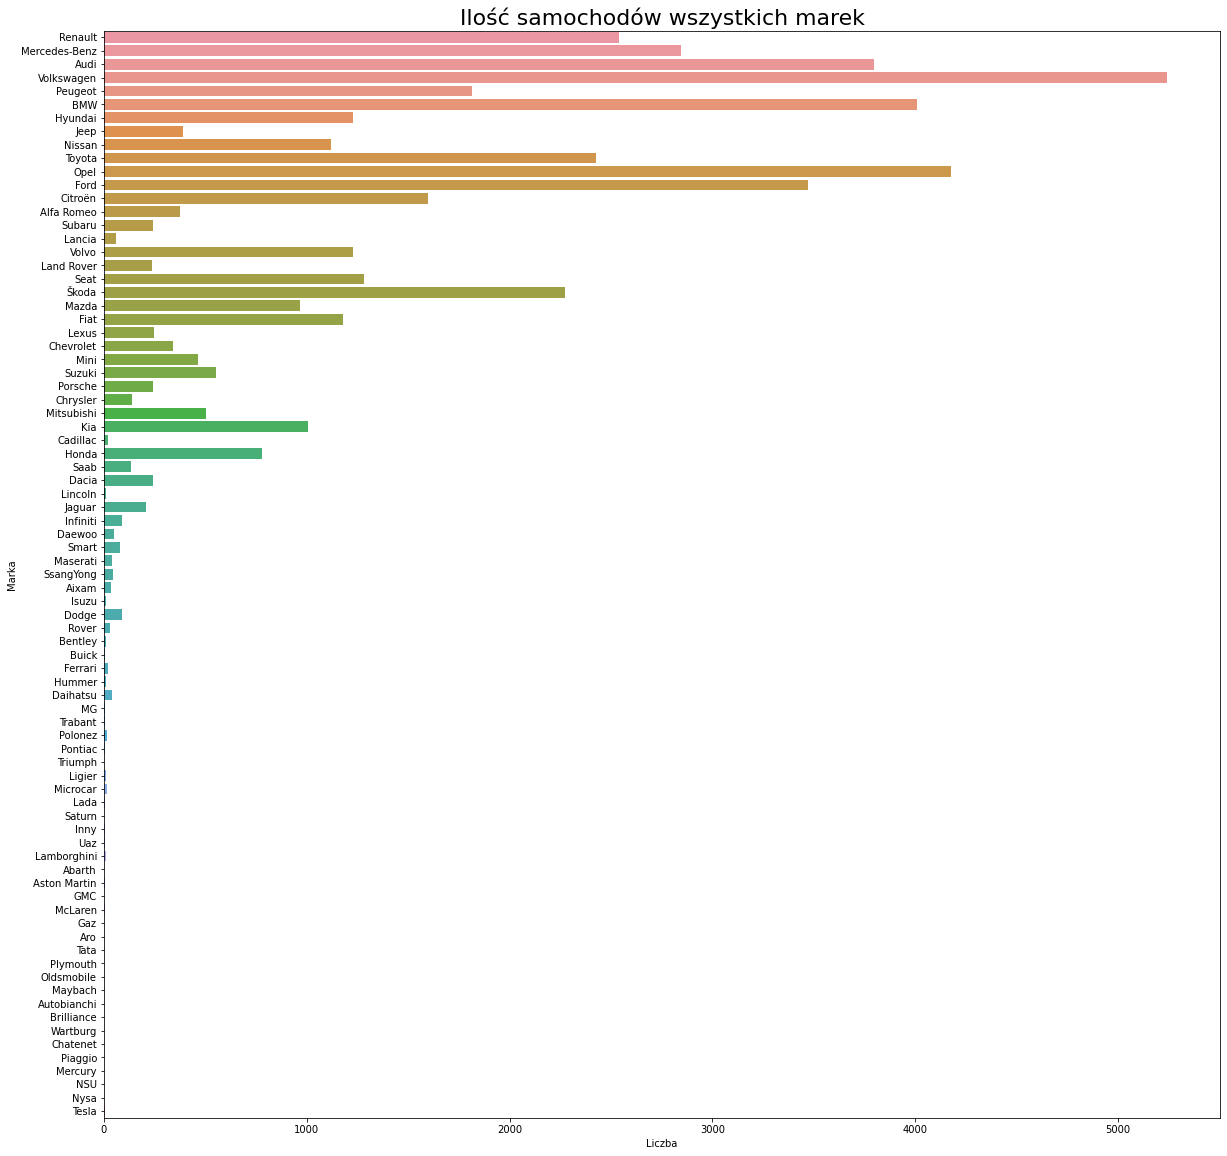

In [130]:
plt.figure(figsize = (20, 20))
sns.countplot(y = dane.Marka)
plt.title("Ilość samochodów wszystkich marek", fontsize = 22)
plt.xlabel('Liczba')
plt.show()

Jak widać najpopularniejszymy markami są Volksvagen, Opel, BMW, a Audi Ford próbują je dogonić.

### 4.3 Wykres zliczający liczbę samochodów z różnych roczników

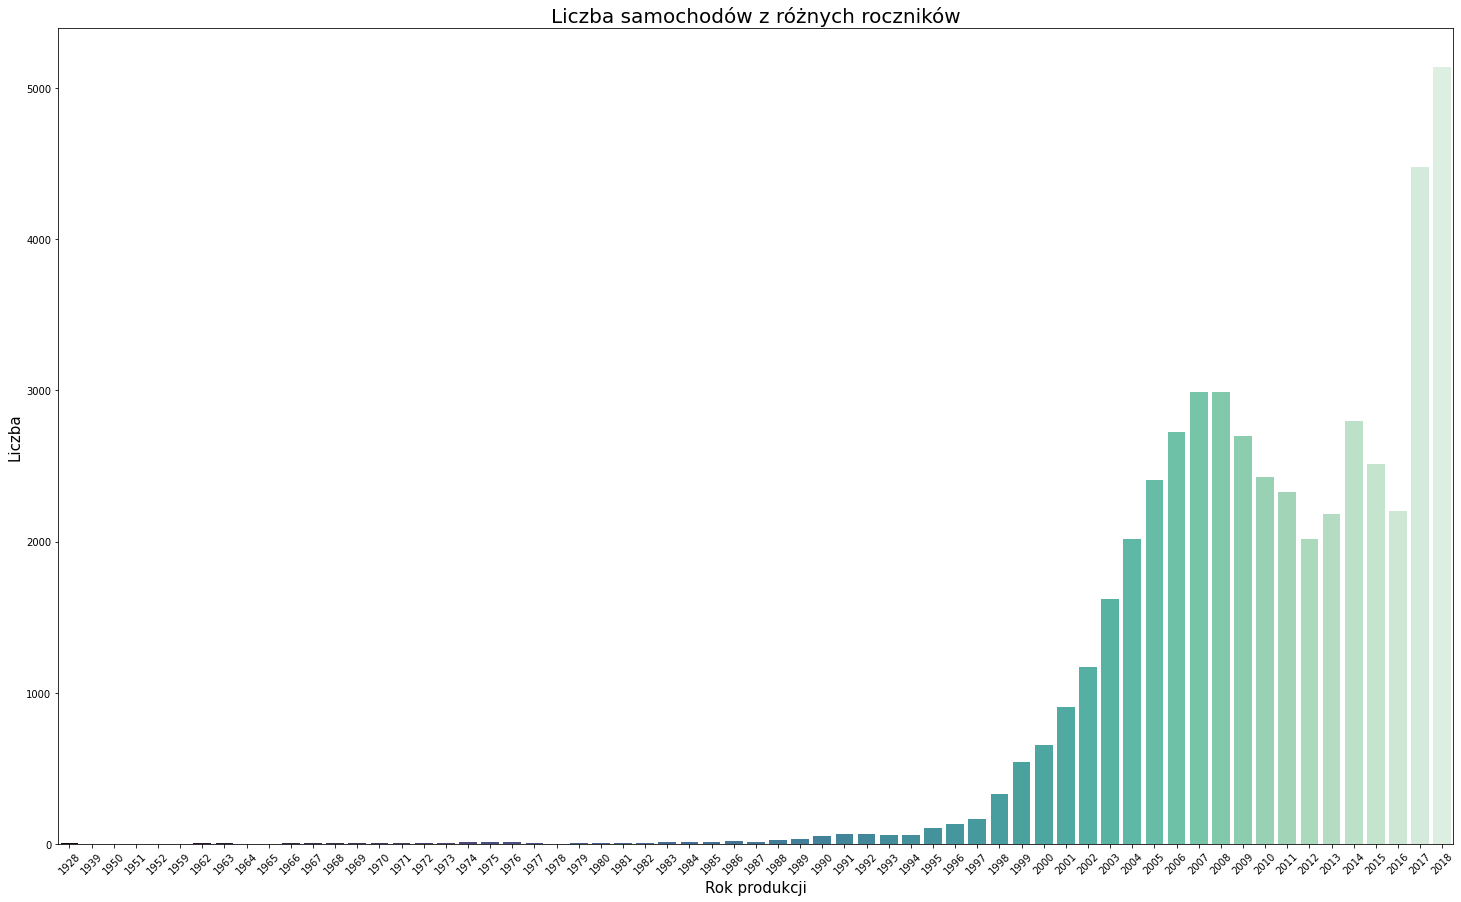

In [131]:
plt.figure(figsize = (25, 15))
sns.countplot(dane.Rok_produkcji, palette = 'mako')
plt.title("Liczba samochodów z różnych roczników", fontsize = 20)
plt.xlabel('Rok produkcji', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Liczba', fontsize=15)
plt.show()

Im nowsze samochody tym jest ich więcej na portalu ogłoszeniowym. Kolejna wyraźna górka to samochody z roczników 2006-2007.

### 4.4 Wykres - Rodzaj skrzyni biegów

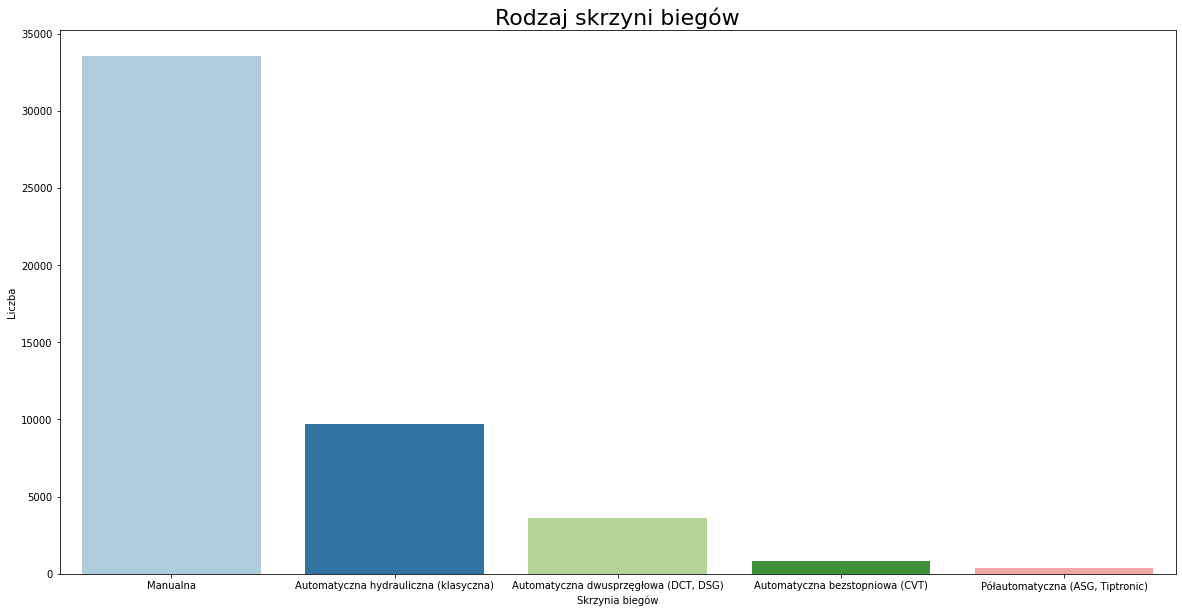

In [132]:
plt.figure(figsize=(20,10))
sns.countplot(dane.Skrzynia_biegow, palette='Paired')
plt.title('Rodzaj skrzyni biegów', fontsize=22)
plt.xlabel('Skrzynia biegów')
plt.ylabel('Liczba')
plt.show()

Skrzynie automatyczne, nawet zsumowane, nie przekroczą popularności skrzyni manualnej.

### 4.5 Wykres - Średnia cena vs skrzynia biegów

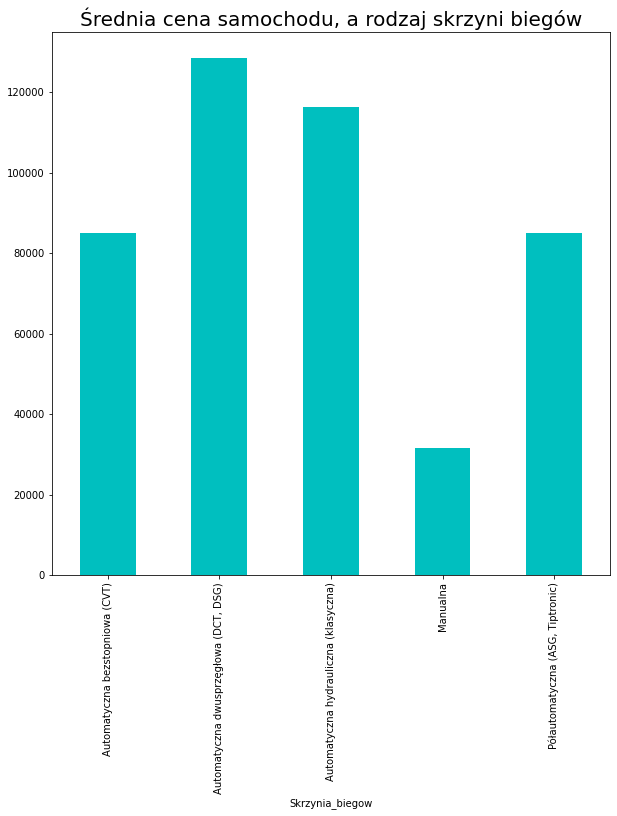

In [133]:
plt.figure(figsize = (10, 10))
dane.groupby('Skrzynia_biegow')['Cena'].mean().plot(kind = 'bar', color = 'c')
plt.title("Średnia cena samochodu, a rodzaj skrzyni biegów", fontsize = 20)
plt.show()

Mimo iż skrzynie automatyczne są zdecydowanie mniej popularne w Polsce, to samochody ze skrzyniami automatycznymi są kilkukrotnie droższe.

### 4.6 Wykres - Rodzaj paliwa

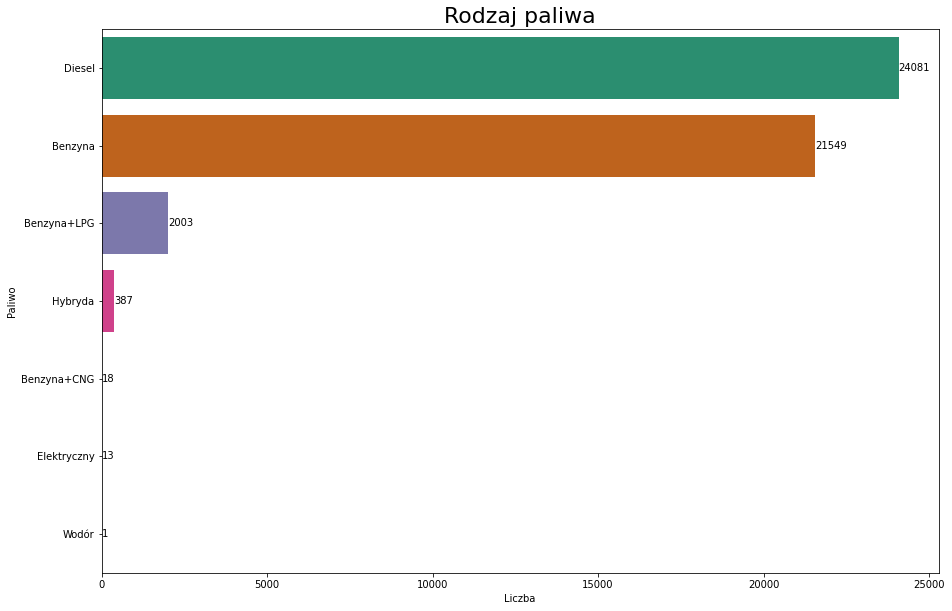

In [134]:
plt.figure(figsize = (15, 10))
ax = sns.countplot(y = dane['Paliwo'], data=dane, order=dane['Paliwo'].value_counts().index, palette = 'Dark2')
ax.bar_label(ax.containers[0])
plt.title('Rodzaj paliwa', fontsize=22)
plt.xlabel('Liczba')
plt.show()

Wykres przedstawia powszechność danych rodzajów paliw używanych do napędzania aut. Bez większego zaskoczenia samochodów z silnikiem Diesla jest podobna ilośc co tych z silnikiem benzynowym i beznzynowych z instalacją gazową.
Elektrycznych aut jest bardzo mało, a według danych jest nawet jedno z silniekiem napędzanym wodorem.

### 4.7 Wykres - Typy aut

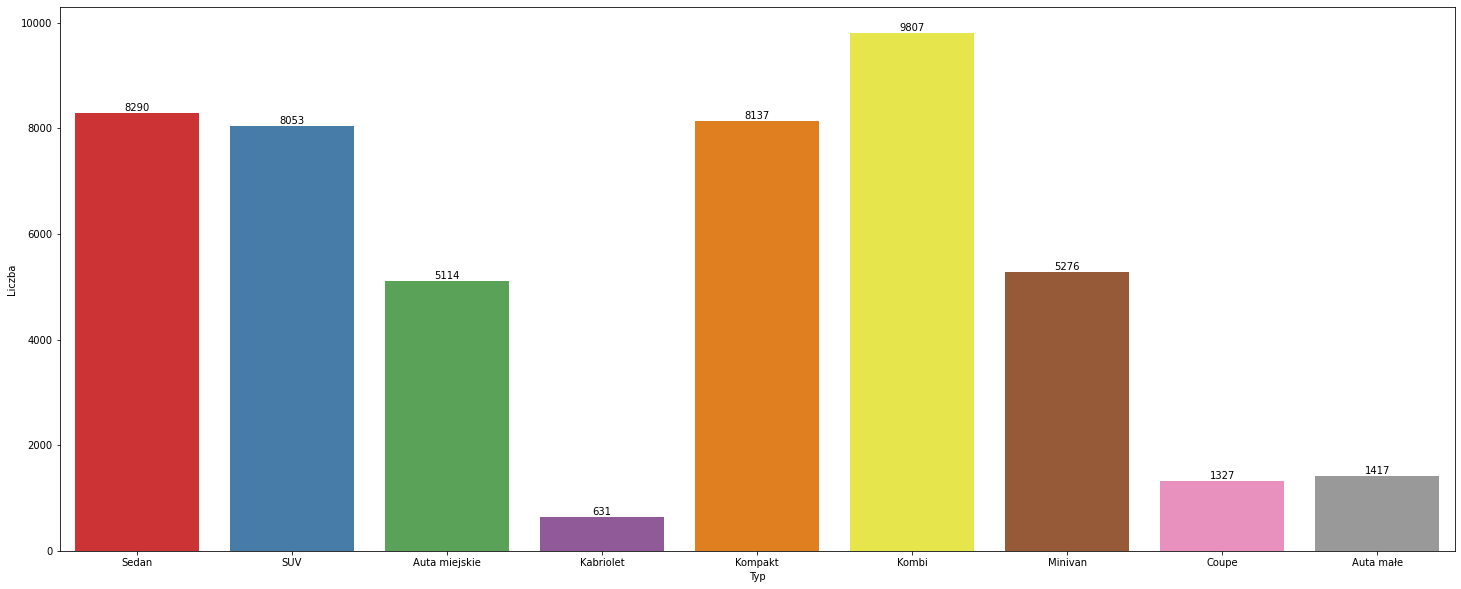

In [135]:
plt.figure(figsize=(25,10))
ax = sns.countplot(dane.Typ, palette='Set1')
ax.bar_label(ax.containers[0])
plt.ylabel('Liczba')
plt.show()

Kilka typów szczególnie popularnych z kombi na czele.

###4.8 Wykres-  Średnia cena samochodu z danego rocznika

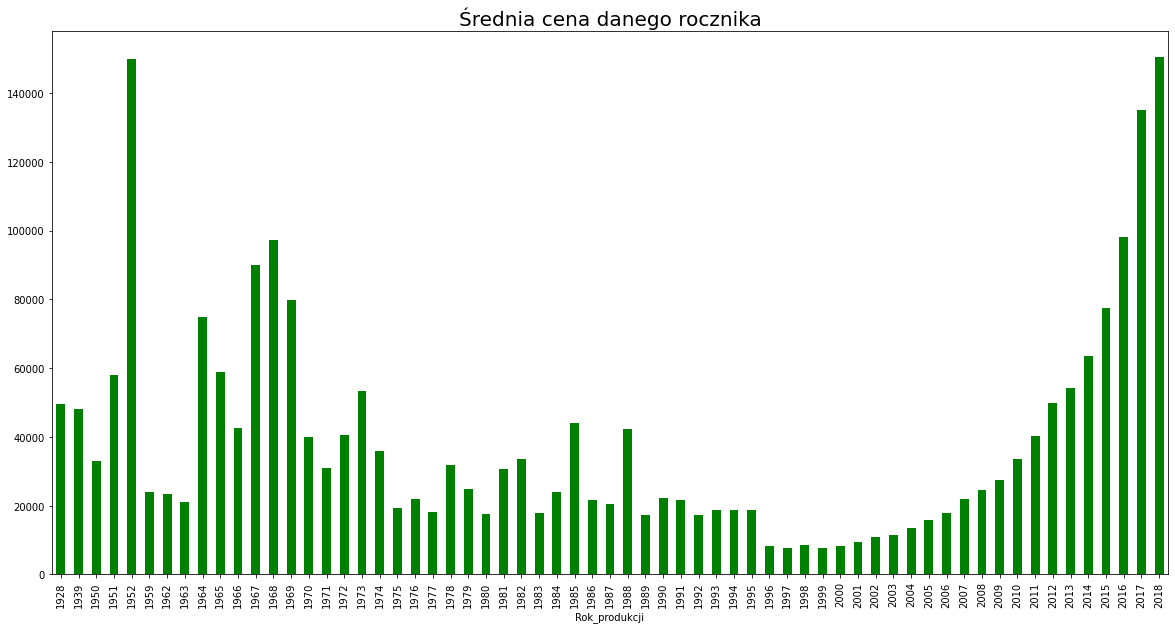

In [136]:
plt.figure(figsize = (20, 10))
dane.groupby('Rok_produkcji')['Cena'].mean().plot(kind = 'bar', color = 'g')
plt.title("Średnia cena danego rocznika", fontsize = 20)
plt.show()

Samochody tanieją do najniższego poziomu po około 20 latach. Następnie ich ceny delikatnie wzrastają, a w wieku około 50 lat ich ceny wyraźnie rosną.

### 4.9 Wykres - Średnie ceny aut w zależności od producenta

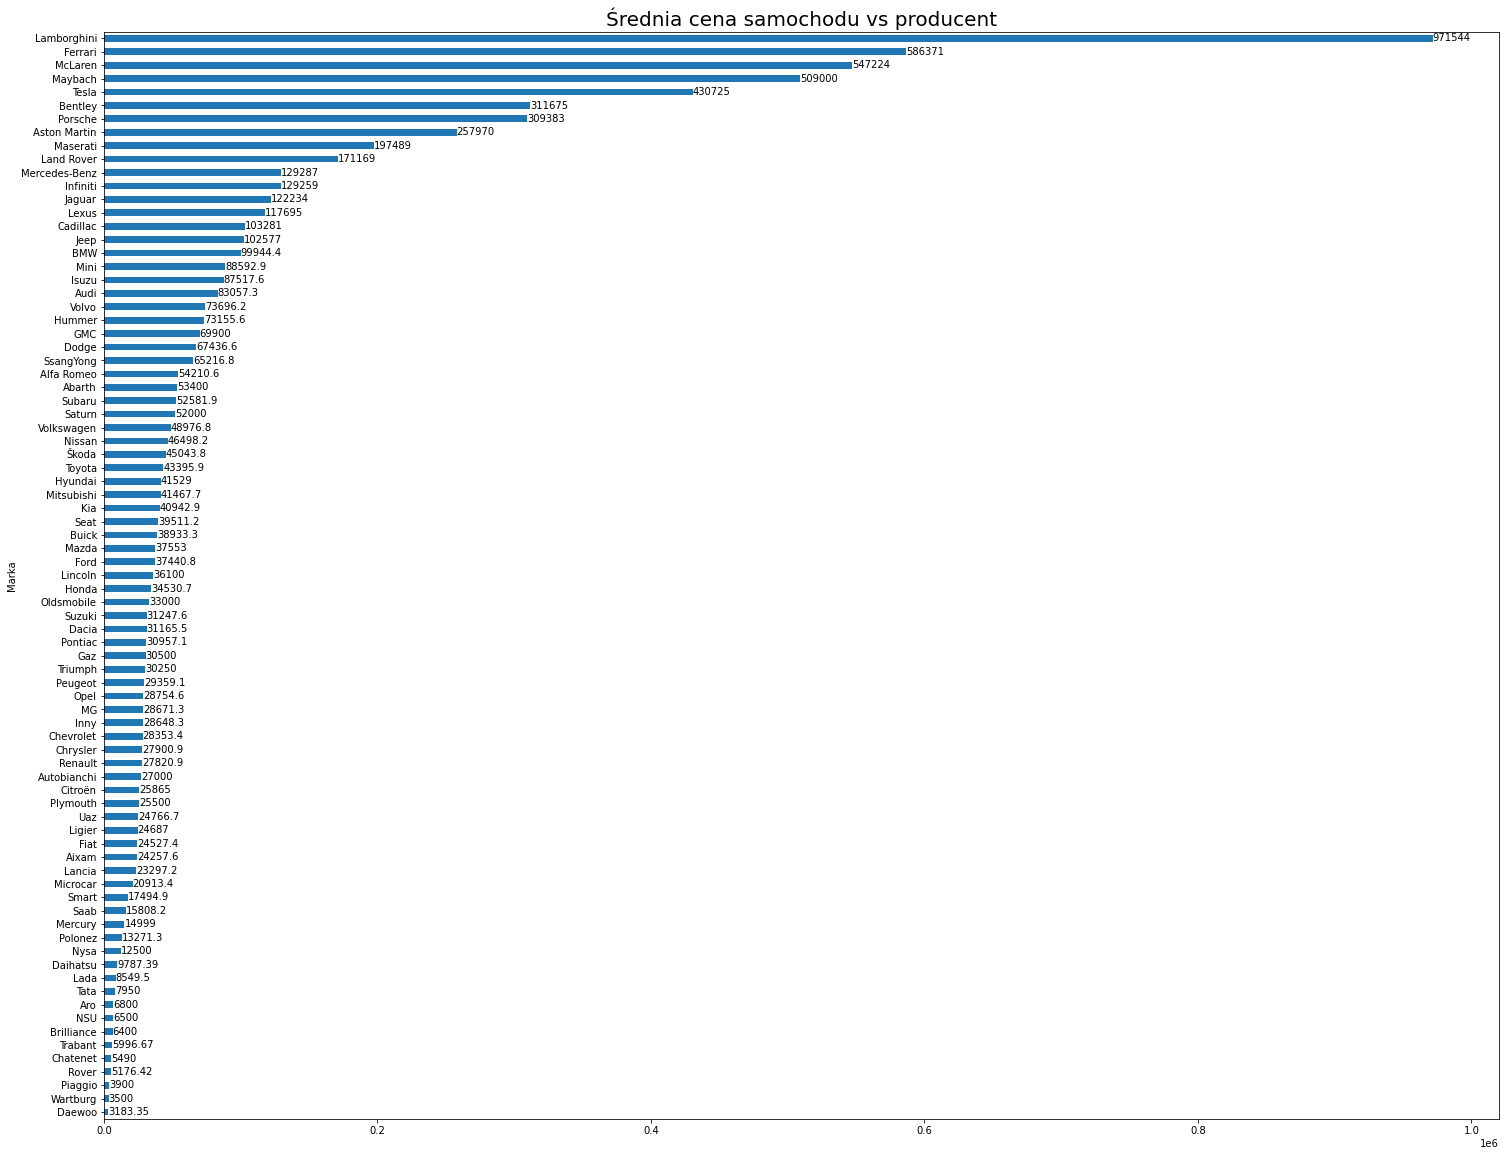

In [137]:
plt.figure(figsize = (25, 20))
ax = dane.groupby('Marka')['Cena'].mean().sort_values(ascending=True).plot.barh()
ax.bar_label(ax.containers[0])
plt.title("Średnia cena samochodu vs producent", fontsize = 20)
plt.show()

Wykres pokazuje, że oczywiście najdroższe są auta luksusowe jak Lamborghini czy Ferrari. Najtańszymi autami są samochody z nieistniejącego już Daewoo.

### 4.10 Wykres - Marka i średnia moc w KM

<AxesSubplot:title={'center':'Marka i średnia moc w KM'}, ylabel='Marka'>

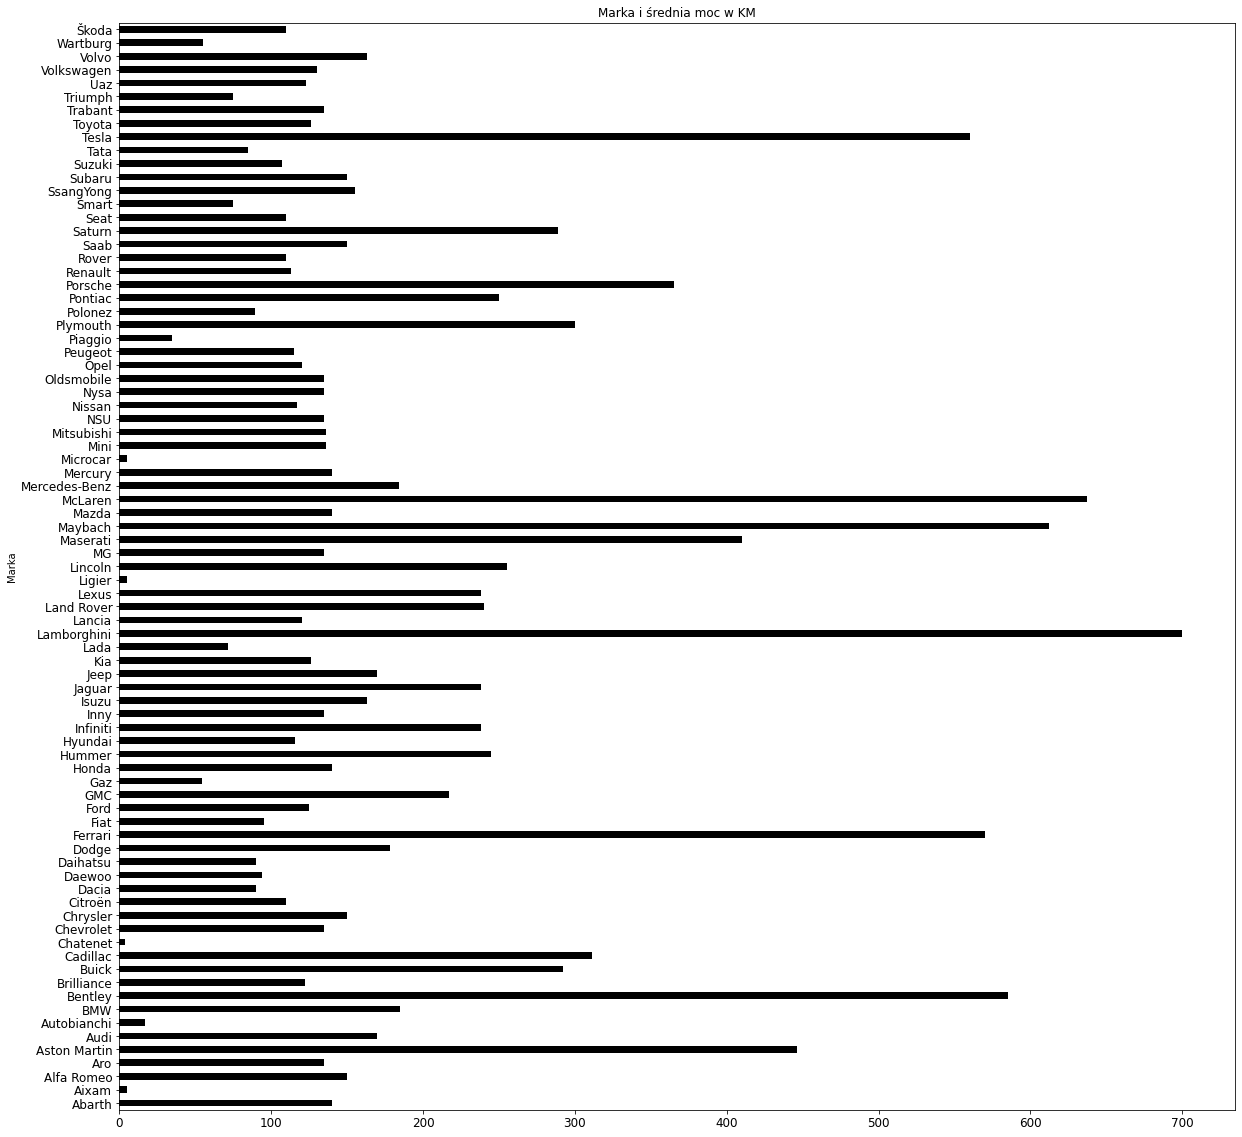

In [138]:
plt.figure(figsize = (20, 20))
plt.title('Marka i średnia moc w KM')
dane.groupby('Marka').median()['Moc'].plot(kind = 'barh', fontsize = 12, color = 'black')

Jak widać na powyższym wykresie kilka marek najdroższych marek posiada równie często najwyższą moc.

### 4.11 Mapa ciepła

<AxesSubplot:>

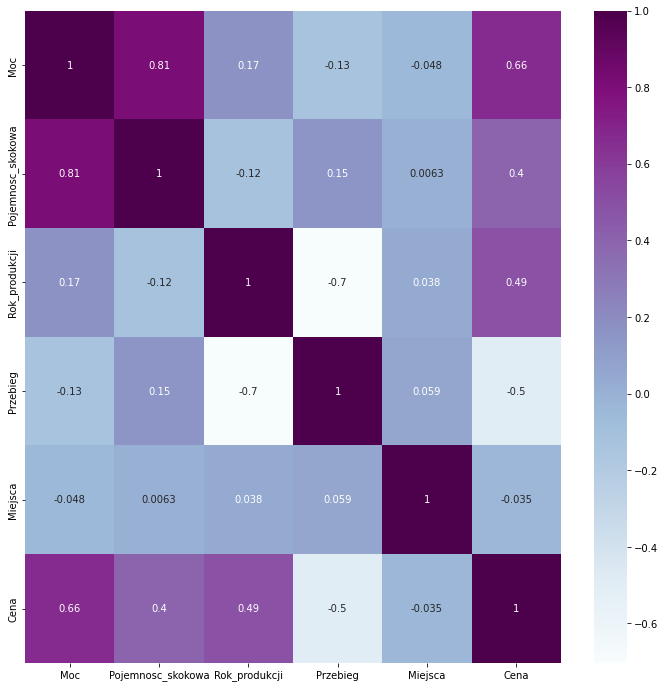

In [139]:
plt.figure(figsize = (12, 12))
dane_liczbowe = ['Moc', 'Pojemnosc_skokowa','Rok_produkcji', 'Przebieg', 'Miejsca', 'Cena']
heatmap_data = dane[dane_liczbowe].corr()
sns.heatmap(heatmap_data, cmap = 'BuPu', annot = True)

Mapa ciepła wykazuje dość silną korelację, która wydaje się oczywista - im większy litraż silnika, tym większa moc. 
Jak można było wnioskować również z poprzednich wykresów cena jest też dość zauważalnie powiązana z mocą samochodu.
Zaobserwować można, że wystepuje ujemna korelacja roku produkcji i przebiegu oraz ceny z przebiegiem. Im wyższy przebieg tym niższa cena i niższy rok produkcji (auto jest zwyczajnie starsze).

### 4.12 Wykres liniowy modelu pojemności skokowej i mocy silnika

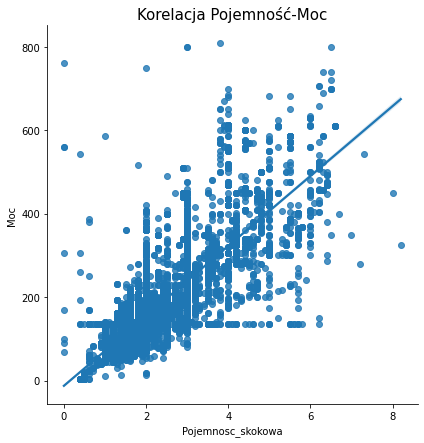

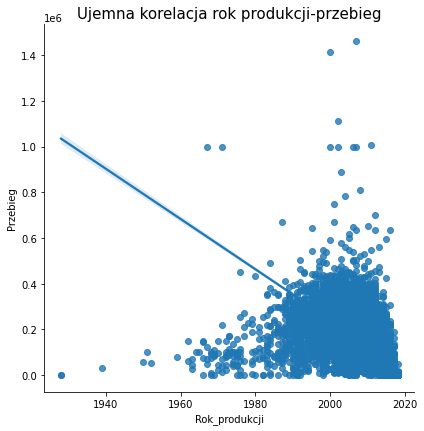

In [140]:
sns.lmplot(x = 'Pojemnosc_skokowa', y = 'Moc', data = dane, height=6)
plt.title('Korelacja Pojemność-Moc', fontsize=15)
plt.show()
print('\n')
sns.lmplot(x = 'Rok_produkcji', y = 'Przebieg', data = dane, height=6)
plt.title('Ujemna korelacja rok produkcji-przebieg', fontsize=15)
plt.show()

Tu jeszcze raz powiązanie pojemności z mocą i przebiegu z datą produkcji, tym razem na wykresie liniowym modelu (LMplot)

### 4.13 Wykres ramka-wąsy pojemności silnika

<AxesSubplot:title={'center':'Pojemność silnika w litrach'}, xlabel='Pojemnosc_skokowa'>

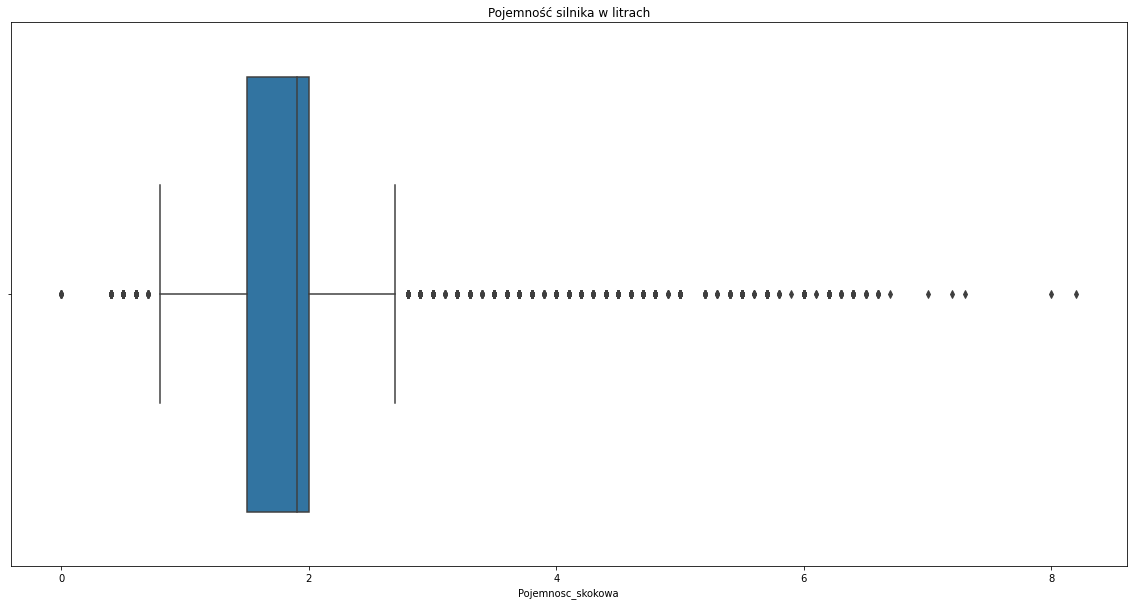

In [142]:
plt.figure(figsize = (20, 10))
plt.title('Pojemność silnika w litrach')
sns.boxplot(dane['Pojemnosc_skokowa'])

Jak widać na powyższym wykresie pudełkowym, w Polsce jest na tyle dużo pojazdów z silnikami o pojemności trochę poniżej dwóch litrów, że ich mediana trafia na 1,9l, a te powyżej ~2,4, są traktowane jako wartości odstjące.

In [145]:
dane['Pojemnosc_skokowa'].median()

1.9

# 5.1 Przygotowanie danych dla potrzeb ML

### 5.2 Losowanie/tasowanie danych

By model nauczył się możliwie najskuteczniej, dane muszą być zróżnicowane. Dlatego się je losuje/tasuje.

In [146]:
potasowane_dane = shuffle(dane, random_state=100)
y = potasowane_dane['Cena']
x = potasowane_dane.drop(['Cena'], axis=1)

### 5.3 Podział na dane treningowe i testowe

In [147]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=100)

In [148]:
print("Rozmiar wejściowych danych treningowych: {}".format(X_train.shape))
print("Rozmiar wyjściowych danych treningowych: {}".format(y_train.shape))
print("Rozmiar wejściowych danych testowych: {}".format(X_test.shape))
print("Rozmiar wyjściowych danych testowych: {}".format(y_test.shape))

Rozmiar wejściowych danych treningowych: (38441, 14)
Rozmiar wyjściowych danych treningowych: (38441,)
Rozmiar wejściowych danych testowych: (9611, 14)
Rozmiar wyjściowych danych testowych: (9611,)


### 5.4 Enkodowanie wartośći kategorycznych do liczbowych

By model skutecznie mógł się uczyć enkoduje się wartości kategoryczne do liczbowych - zrozumiałych łatwiej dla maszyny.
Cechy z dużą ilością wartości unikalnych enkodujemy za pomocą np. funkji targetEncoder jak w tej pracy. Tam gdzie jest ich mniej stosujemy metodę gorącej jedyki.

In [151]:
#tak wyglądały przed enkodowaniem
dane.head()

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Cena,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
0,Renault,Fluence,2013,1.6,110.0,Benzyna+LPG,25900.0,172000.0,Biały,Sedan,5,Na przednie koła,Nie,Używane,Manualna
1,Mercedes-Benz,Klasa G,2016,3.0,245.0,Diesel,434900.0,52904.0,Szary,SUV,5,4x4 (stały),Tak,Używane,Automatyczna hydrauliczna (klasyczna)
2,Audi,A5,2011,2.0,190.0,Benzyna,41900.0,56000.0,Czarny,Sedan,4,Na przednie koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
3,Volkswagen,Polo,2007,1.2,70.0,Benzyna,14900.0,88000.0,Srebrny,Auta miejskie,5,Na przednie koła,Tak,Używane,Manualna
4,Peugeot,206 CC,2001,2.0,136.0,Benzyna,5900.0,176000.0,Srebrny,Kabriolet,4,Na przednie koła,Tak,Używane,Manualna


In [153]:
# tu gdzie jest wiele wartości używamy np TargetEncoder
encoder = TargetEncoder(cols = 'Rok_produkcji')
encoder.fit(X_train['Rok_produkcji'], y_train.to_frame()['Cena'] )

TargetEncoder(cols=['Rok_produkcji'])

In [154]:
X_train['Rok_produkcji'] = encoder.transform(X_train['Rok_produkcji'])
X_test['Rok_produkcji'] = encoder.transform(X_test['Rok_produkcji'])

In [155]:
# Enkodujemy pozostałe dane
#Model
encoder = TargetEncoder(cols = 'Model')
encoder.fit(X_train['Model'], y_train.to_frame()['Cena'] )
X_train['Model'] = encoder.transform(X_train['Model'])
X_test['Model'] = encoder.transform(X_test['Model'])
#Marka
encoder = TargetEncoder(cols = 'Marka')
encoder.fit(X_train['Marka'], y_train.to_frame()['Cena'] )
X_train['Marka'] = encoder.transform(X_train['Marka'])
X_test['Marka'] = encoder.transform(X_test['Marka'])
#Kolor
encoder = TargetEncoder(cols = 'Kolor')
encoder.fit(X_train['Kolor'], y_train.to_frame()['Cena'] )
X_train['Kolor'] = encoder.transform(X_train['Kolor'])
X_test['Kolor'] = encoder.transform(X_test['Kolor'])

Dane wyglądają teraz tak:

In [156]:
X_train.head()

,Marka,Model,Rok_produkcji,Pojemnosc_skokowa,Moc,Paliwo,Przebieg,Kolor,Typ,Miejsca,Naped,ASO,Stan,Skrzynia_biegow
16660,83581.804086,29941.117647,17811.285450,2.0,200.0,Benzyna,126463.0,64804.038630,Kompakt,4,Na przednie koła,Nie,Używane,Manualna
40201,129463.390598,28169.408955,22679.673097,2.8,170.0,Benzyna+LPG,212000.0,28994.238012,Sedan,5,Na tylne koła,Nie,Używane,Automatyczna hydrauliczna (klasyczna)
14749,43465.710314,48250.155251,24802.114733,2.2,136.0,Diesel,188000.0,66904.587294,SUV,5,4x4 (dołączany automatycznie),Nie,Używane,Manualna
19220,53866.489130,57170.016738,63284.653587,2.0,200.0,Benzyna,25000.0,66904.587294,Coupe,4,Na tylne koła,Nie,Używane,"Automatyczna dwusprzęgłowa (DCT, DSG)"
5989,37447.470465,29635.386984,9513.735054,1.6,135.0,Benzyna,177000.0,32454.800171,Kompakt,5,Na przednie koła,Nie,Używane,Manualna


### 5.5 Kodowanie metodą gorącej jedynki

Zbiór treningowy i testowy zamieniane są na zbiory zawierające wektory z gorącą jedynką i przypisywane są do nowej zmiennej.

In [157]:
encoder = OneHotEncoder()
encoder.fit(X_train[['Paliwo', 'Typ', 'Naped', 'ASO', 'Stan','Skrzynia_biegow']])
one_hot_encoded_output_train = encoder.transform(X_train[['Paliwo', 'Typ', 'Naped', 'ASO', 'Stan','Skrzynia_biegow']])
one_hot_encoded_output_test = encoder.transform(X_test[['Paliwo', 'Typ', 'Naped', 'ASO', 'Stan','Skrzynia_biegow']])

##### Lączymy zbiory do jednego DF tylko z wartościami liczbowymi łatwymi do przetwarzania przez model

In [161]:
X_train = pd.concat([X_train, one_hot_encoded_output_train], axis = 1)
X_test = pd.concat([X_test, one_hot_encoded_output_test], axis = 1)

##### Usuwamy kolumny, które zostały wcześniej przekonwertowane i nie są wartościami liczbowymi, bo ich warianty zostały już dodane do ramki danych.

In [162]:
X_train.drop(['Paliwo', 'Typ', 'Naped', 'ASO', 'Stan','Skrzynia_biegow'], axis = 1, inplace = True)
X_test.drop(['Paliwo', 'Typ', 'Naped', 'ASO', 'Stan','Skrzynia_biegow'], axis = 1, inplace = True)

### 5.6 Skalowanie i normalizacja

Skalujemy wartości tak by ich średnia była równa 0, a odchylenie standardowe wynosiło 1. To ułatwia maszynie uczenie.

In [164]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)

numpy.ndarray

# 6.0 Uczenie maszynowe - Analizy

### 6.1 Regresja Liniowa

Tworzymy model predykcyjny przy pomocy regresji liinowej.
Tu model uczy się na danych treningowych:

In [181]:
model = LinearRegression()
model.fit(X_train_new, y_train)

LinearRegression()

Poniżej wytrenowany model przewiduje ceny na podstawie danych testowych przeskalowanych. Wynik zapisujemy w zmiennej.

In [182]:
y_predict = model.predict(X_test_new)

### Zamieniamy wynik do DF, by stworzyć jedną ramkę, której użyjemy do wizualizacji wyników

In [183]:
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])

In [184]:
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

In [185]:
results.nlargest(200, 'Cena')

,Predicted Output,Cena
6935,431232.0,2078000.0
8745,968128.0,1230000.0
7048,977536.0,1114997.0
4112,971008.0,999999.0
6873,351744.0,984248.0
...,...,...
1843,176576.0,299000.0
7071,251520.0,299000.0
8807,340352.0,299000.0
2772,309312.0,296800.0


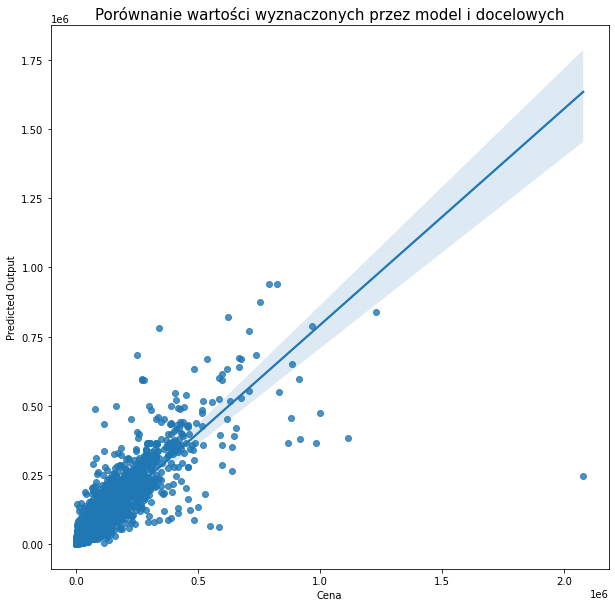

In [ ]:
plt.figure(figsize=(10,10))
sns.regplot(data = results, y='Predicted Output', x='Cena')
plt.title('Porównanie wartości wyznaczonych przez model i docelowych', fontsize=15)
plt.show()

Model ma rozsądną dokładność. Im niższe ceny tym lepiej trafia.


Tak samo będziemy postępować z pozostałymi modelami, by wybrać najlepszy dla naszego celu.

### 6.2 Metoda K-Najbliższych sąsiadów

In [193]:
model = KNeighborsRegressor(n_neighbors = 2)
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

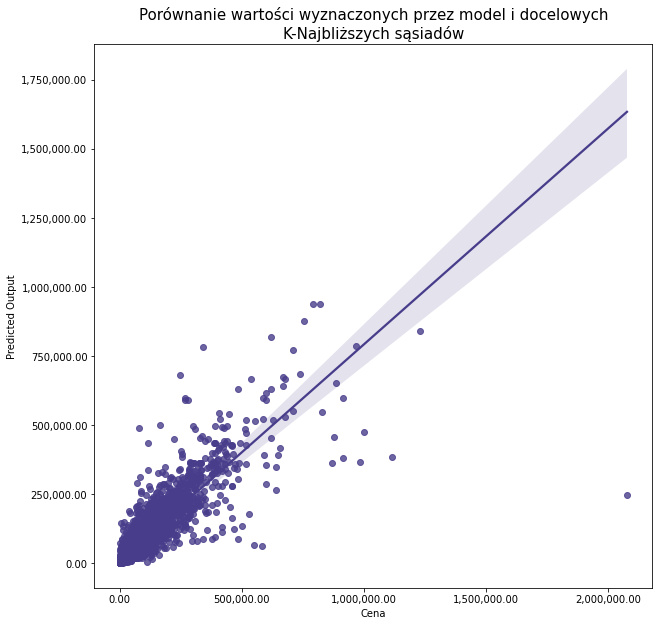

In [194]:
plt.figure(figsize = (10, 10))
g = sns.regplot(data = results, y = 'Predicted Output', x = 'Cena', color = 'darkslateblue')
plt.title("Porównanie wartości wyznaczonych przez model i docelowych\nK-Najbliższych sąsiadów", fontsize = 15)
yLab = ['{:,.2f}'.format(y) for y in g.get_yticks()/1]
g.set_yticklabels(yLab)
xLab = ['{:,.2f}'.format(x) for x in g.get_xticks()/1]
g.set_xticklabels(xLab)
plt.show()

Skuteczność bardzo zbliżona do regresji liniowej.

### 6.3 Regresja metodą cząstkowych najmniejszych kwadratów - PLS (Partial Least Squares)

In [195]:
model = PLSRegression(n_components = 20)
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

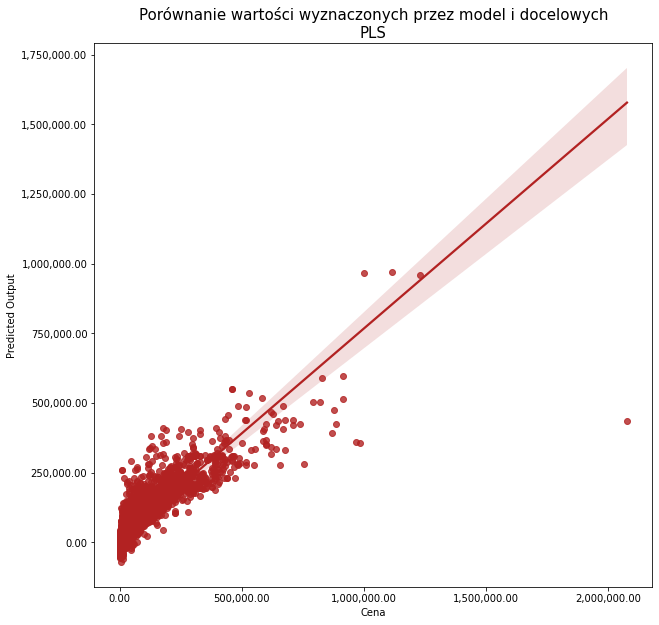

In [197]:
plt.figure(figsize = (10, 10))
g = sns.regplot(data = results, y = 'Predicted Output', x = 'Cena', color = 'firebrick')
plt.title("Porównanie wartości wyznaczonych przez model i docelowych\nPLS", fontsize = 15)
yLab = ['{:,.2f}'.format(y) for y in g.get_yticks()/1]
g.set_yticklabels(yLab)
xLab = ['{:,.2f}'.format(x) for x in g.get_xticks()/1]
g.set_xticklabels(xLab)
plt.show()

Zdecydowanie bliżej wartości oczekiwanej.

### 6.4 Regresor drzewa decyzyjnego (Decision Tree Regressor)

In [203]:
model = DecisionTreeRegressor(splitter = 'random')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

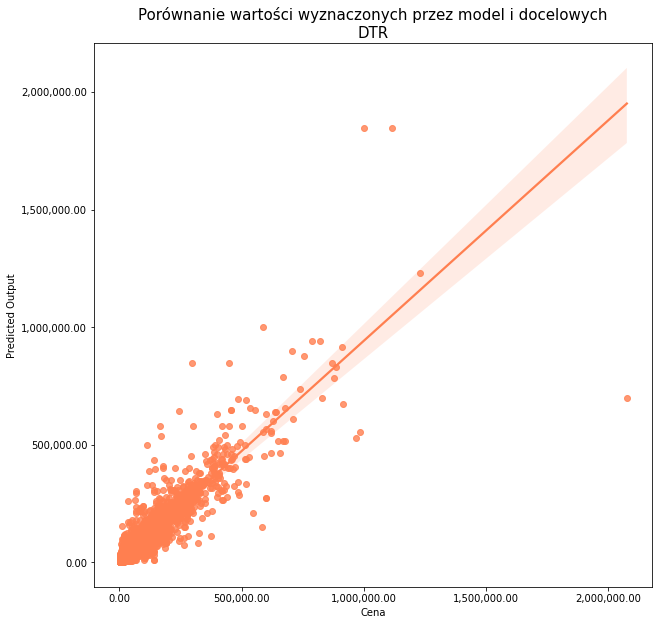

In [204]:
plt.figure(figsize = (10, 10))
g = sns.regplot(data = results, y = 'Predicted Output', x = 'Cena', color = 'coral')
plt.title("Porównanie wartości wyznaczonych przez model i docelowych\nDTR", fontsize = 15)
yLab = ['{:,.2f}'.format(y) for y in g.get_yticks()/1]
g.set_yticklabels(yLab)
xLab = ['{:,.2f}'.format(x) for x in g.get_xticks()/1]
g.set_xticklabels(xLab)
plt.show()

### 6.5 Gradient Boosting Regressor

In [205]:
model = GradientBoostingRegressor()
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

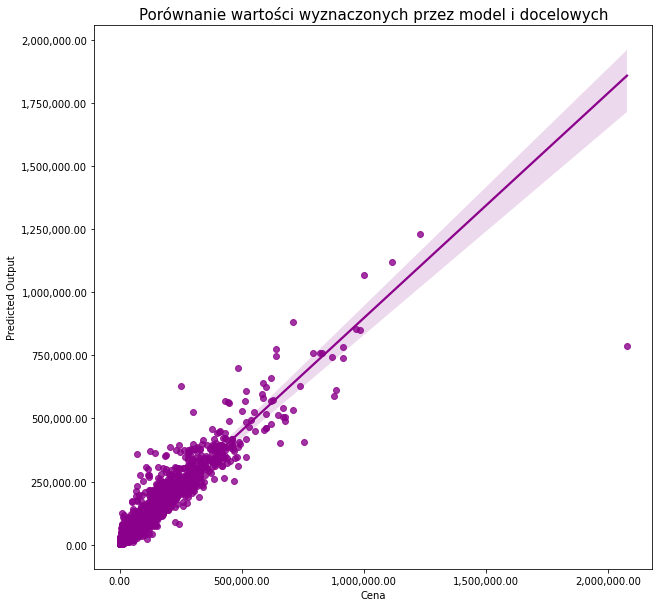

In [206]:
plt.figure(figsize = (10, 10))
g = sns.regplot(data = results, y = 'Predicted Output', x = 'Cena', color = 'darkmagenta', marker = 'o')
plt.title("Porównanie wartości wyznaczonych przez model i docelowych", fontsize = 15)
yLab = ['{:,.2f}'.format(y) for y in g.get_yticks()/1]
g.set_yticklabels(yLab)
xLab = ['{:,.2f}'.format(x) for x in g.get_xticks()/1]
g.set_xticklabels(xLab)
plt.show()

### 6.6 MLP Regressor (Multi-layer Perceptron regressor)

In [207]:
model = MLPRegressor(hidden_layer_sizes = 50, alpha = 0.001, solver = 'lbfgs', learning_rate = 'adaptive')
model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Predicted Output'])
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)

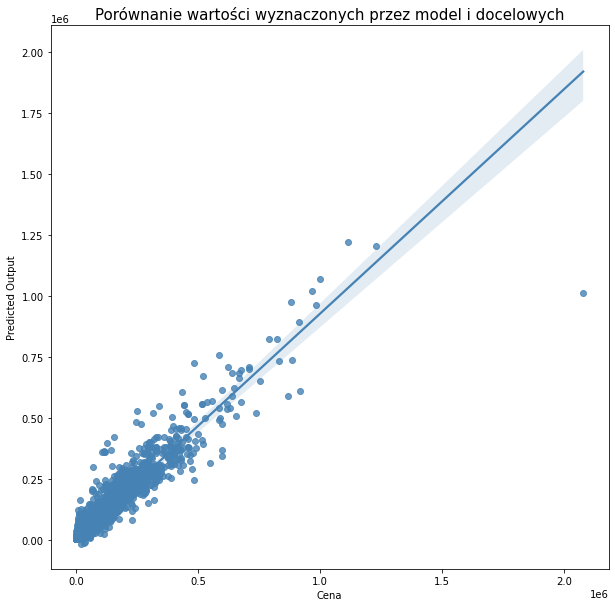

In [208]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Predicted Output', x = 'Cena', color = 'steelblue', marker = 'o')
plt.title("Porównanie wartości wyznaczonych przez model i docelowych", fontsize = 15)
yLab = ['{:,.2f}'.format(y) for y in g.get_yticks()/1]
g.set_yticklabels(yLab)
xLab = ['{:,.2f}'.format(x) for x in g.get_xticks()/1]
g.set_xticklabels(xLab)
plt.show()

Ostatni model zdecydowanie daje najlepsze wyniki. Wartości są najbliższe wartości docelowych. Nawet wartośc odstająca najbardziej (punkt po prawej), mimo, że ciągle daleko od wartości faktycznej, jest bliżej niż w innych modelach. Model najprawdopodobniej uznał, że dodatkowy milion za to co oferuje najdroższe w zbiorze Ferrari, to zdecydoawnie za dużo.
Podsumowując, najlepszy algorytm do wyznaczenia wartości samochodu na podstawie jego podstawowych cech to Multi-layer Perceptron regressor.
